# Statistics on Spectra and comparison on Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-16
- last update : 2024-01-30
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

# Read pandas Series

In [4]:
!ls Data_Auxtel_Spectro/

out_allfittedparams_2021.csv  selected_27sept-07dec2023
out_allfittedparams_2022.csv  spec_series_repo_embargo.csv
out_allfittedparams_2023.csv  spec_series_repo_main.csv
selected_1jan-28feb2023       zp_fall2023.csv
selected_1march-14sept2023


In [5]:
files = [ "Data_Auxtel_Spectro/spec_series_repo_main.csv" , "Data_Auxtel_Spectro/spec_series_repo_embargo.csv"  ]
N = len(files)

In [6]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [7]:
df = pd.concat(all_df)

In [8]:
df.head()

,countVisitperBandperNight
day_obs,
20210218,12
20210707,46
20210908,55
20210909,55
20211005,18


## compute

In [9]:
def convertNumToDatestr(num):
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)

In [10]:
df["dateobs"] = [ convertNumToDatestr(num) for num in df.index ]

In [11]:
df.head()

,countVisitperBandperNight,dateobs
day_obs,,
20210218,12,2021-02-18
20210707,46,2021-07-07
20210908,55,2021-09-08
20210909,55,2021-09-09
20211005,18,2021-10-05


In [12]:
df["cumsum"] = df["countVisitperBandperNight"].cumsum()

In [13]:
df.head()

,countVisitperBandperNight,dateobs,cumsum
day_obs,,,
20210218,12,2021-02-18,12
20210707,46,2021-07-07,58
20210908,55,2021-09-08,113
20210909,55,2021-09-09,168
20211005,18,2021-10-05,186


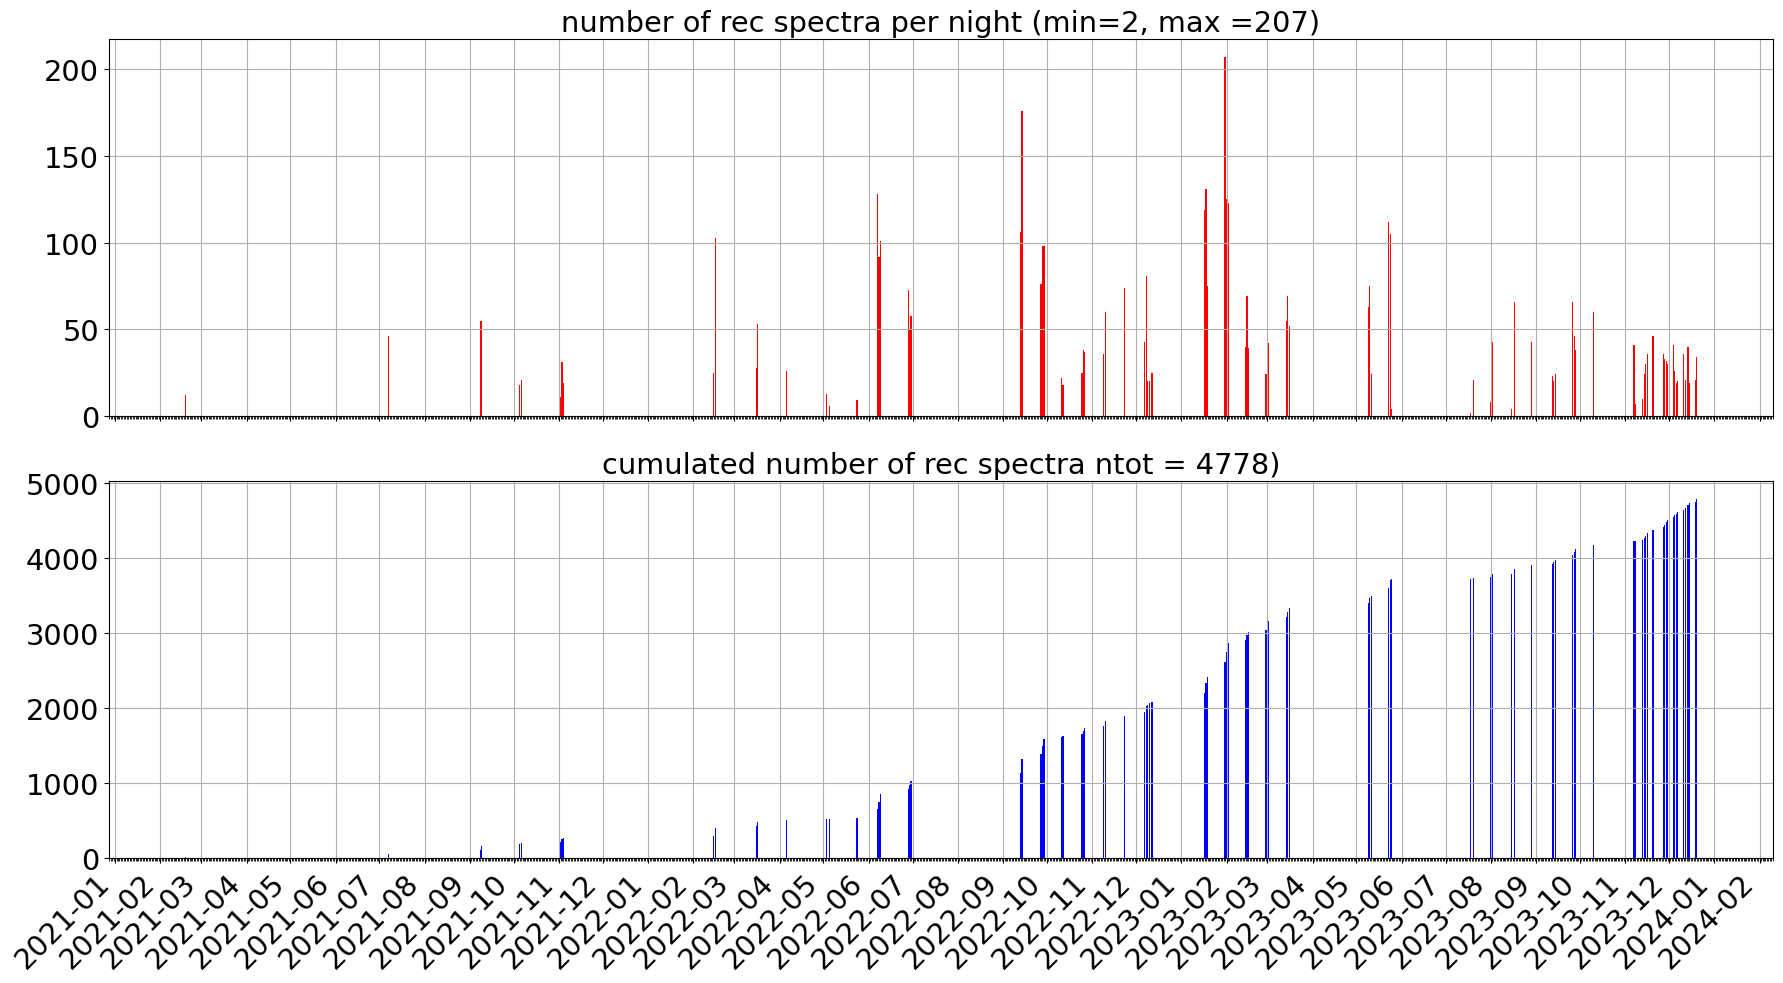

In [14]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(18, 10),sharex=True)


# fit 1
#ax.plot(dt,df_spec_visit.values,marker='o', markersize=15,lw=0)
ax1.bar(df["dateobs"],df["countVisitperBandperNight"],lw=5,facecolor='r')
ax1.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax1.xaxis.set_minor_locator(day_locator)
ax1.xaxis.set_major_formatter(year_month_formatter)
ax1.grid()

minnspec= df["countVisitperBandperNight"].min()
maxnspec= df["countVisitperBandperNight"].max()
totnspec= df["countVisitperBandperNight"].sum()
title1 = f"number of rec spectra per night (min={minnspec}, max ={maxnspec})"
ax1.set_title(title1)

#fig.autofmt_xdate() # rotation
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=45, ha='right')

#ax2.bar(dt,df_spec_visit.cumsum().values,lw=5,facecolor='b')
ax2.bar(df["dateobs"],df["cumsum"],lw=5,facecolor='b')
ax2.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax2.xaxis.set_minor_locator(day_locator)
ax2.xaxis.set_major_formatter(year_month_formatter)
ax2.grid()

#fig.autofmt_xdate() # rotation
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=45, ha='right')
title2 = f"cumulated number of rec spectra ntot = {totnspec})"
ax2.set_title(title2)

plt.tight_layout()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [15]:
top_merra2 = "../../../Merra2"

In [16]:
asm_merra2 = ["MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [17]:
aer_merra2 = ["MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [18]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [19]:
df_asm[0].head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2021-01-01 00:00:00,78309.336,289.73587,289.72906,247.26114,0.005301,0.0,0.0,9.219856,289.53670,1.417040,1.029335,1.653588,1.271824,0.941790,1.593075
2021-01-01 01:00:00,78353.440,288.45830,288.14820,246.95404,0.005294,0.0,0.0,9.299347,287.69740,-0.640781,-0.321693,-0.997959,0.720388,0.370704,1.075519
2021-01-01 02:00:00,78399.140,289.09607,288.32602,246.62802,0.005287,0.0,0.0,9.733832,286.42050,-1.040606,-0.651973,-1.313788,0.071793,0.050780,0.098654
2021-01-01 03:00:00,78434.100,289.61584,288.91230,246.08704,0.005275,0.0,0.0,10.086275,285.64383,-0.592623,-0.392119,-0.690463,-0.301546,-0.178987,-0.397412
2021-01-01 04:00:00,78439.300,289.57867,288.79303,245.58127,0.005264,0.0,0.0,10.178970,284.94794,-0.186442,-0.133778,-0.234019,-0.381485,-0.213192,-0.497831


In [20]:
df_aer[0].head()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
time,,,
2021-01-01 00:30:00,1.196867,0.056970,0.053770
2021-01-01 01:30:00,1.198094,0.057817,0.054558
2021-01-01 02:30:00,1.201883,0.060025,0.056720
2021-01-01 03:30:00,1.209316,0.062329,0.059037
2021-01-01 04:30:00,1.218950,0.064500,0.061218


In [21]:
pwv_m = np.zeros((Nasm,2))
oz_m = np.zeros((Nasm,2))
aer_ang = np.zeros((Naer,2))
aer_tau = np.zeros((Naer,2))

In [22]:
#df_asm[0]['TQV'].describe()

In [23]:
for idx in range(Naer):
    pwv_m[idx,0] =  df_asm[idx].describe()["TQV"]["50%"]
    pwv_m[idx,1] =  df_asm[idx].describe()["TQV"]["std"]
    oz_m[idx,0] =  df_asm[idx].describe()["TO3"]["50%"]
    oz_m[idx,1] =  df_asm[idx].describe()["TO3"]["std"]

In [24]:
df_aer[0].describe()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
count,5832.000000,5832.000000,5832.000000
mean,1.426264,0.046576,0.043925
std,0.117271,0.032615,0.032002
min,0.971963,0.007274,0.006465
25%,1.352238,0.028868,0.026681
50%,1.429485,0.038301,0.035667
75%,1.507141,0.051973,0.049031
max,1.775150,0.337077,0.331127


In [25]:
for idx in range(Naer):
    aer_ang[idx,0] =  df_aer[idx].describe()["TOTANGSTR"]["50%"]
    aer_ang[idx,1] =  df_aer[idx].describe()["TOTANGSTR"]["std"]
    aer_tau[idx,0] = df_aer[idx].describe()["TOTEXTTAU"]["50%"]
    aer_tau[idx,1] = df_aer[idx].describe()["TOTEXTTAU"]["std"]

In [26]:
aer_tau

array([[0.03830142, 0.03261549],
       [0.04351095, 0.04671381],
       [0.0361851 , 0.03121508]])

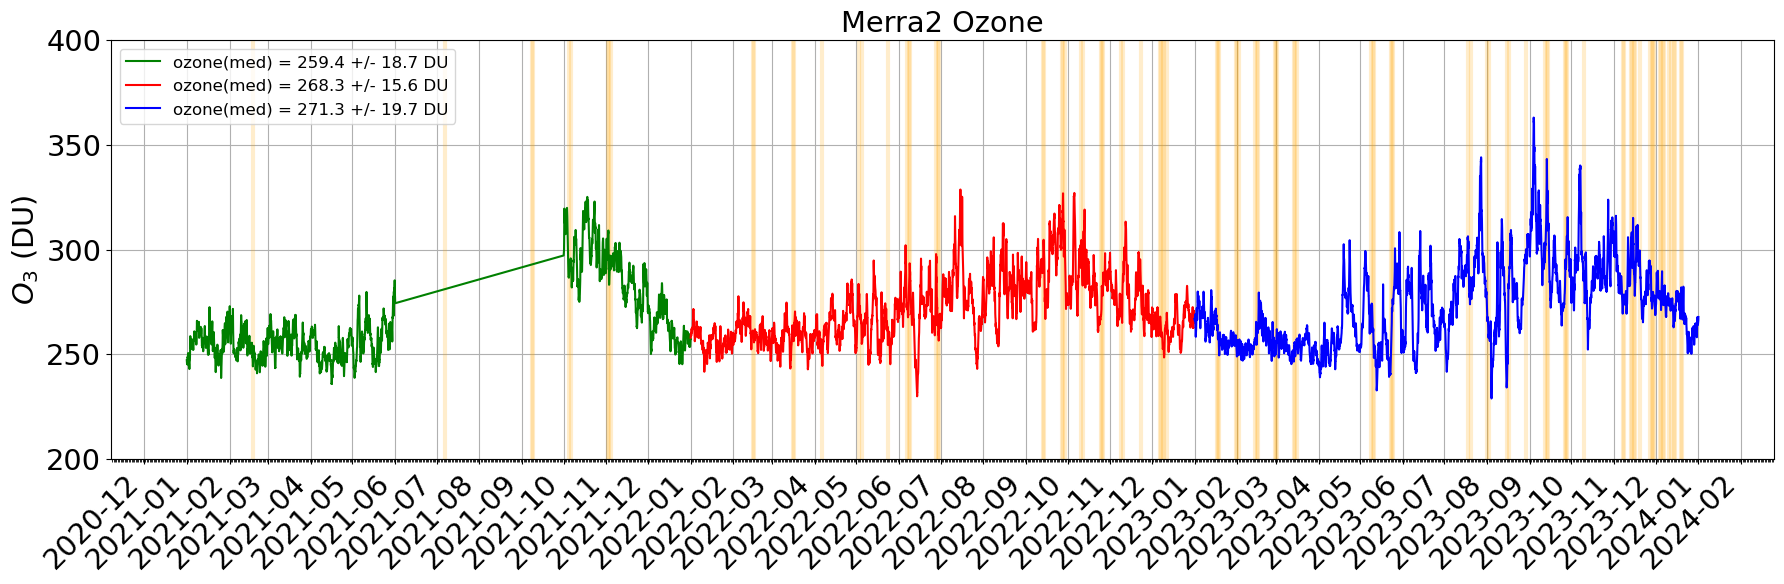

In [27]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

label1 = f"ozone(med) = {oz_m[0,0]:.1f} +/- {oz_m[0,1]:.1f} DU"
label2 = f"ozone(med) = {oz_m[1,0]:.1f} +/- {oz_m[1,1]:.1f} DU"
label3 = f"ozone(med) = {oz_m[2,0]:.1f} +/- {oz_m[2,1]:.1f} DU"
ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-',label=label1)
ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-',label=label2)
ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-',label=label3)

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.legend()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")
plt.tight_layout()
plt.savefig("Merra2_OzoneHistRecord.png")
plt.show()


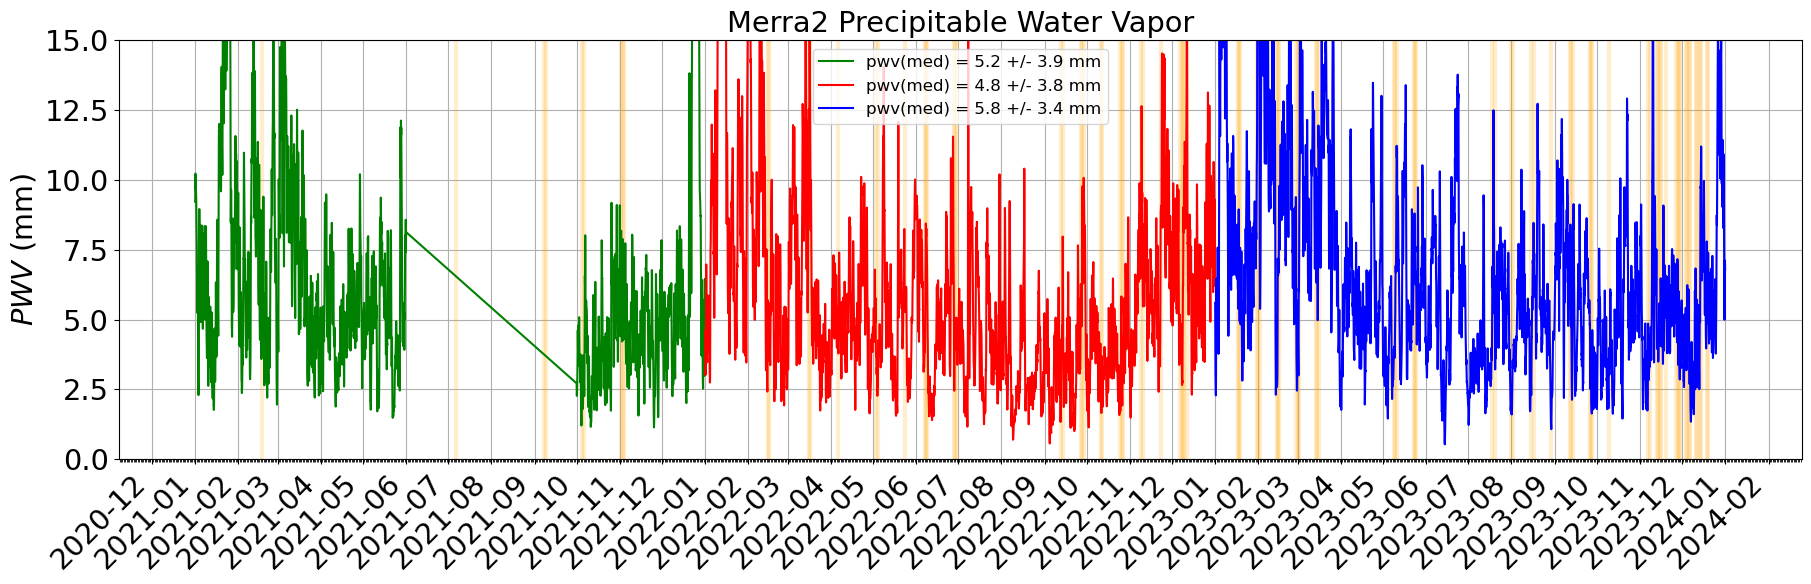

In [28]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

label1 = f"pwv(med) = {pwv_m[0,0]:.1f} +/- {pwv_m[0,1]:.1f} mm"
label2 = f"pwv(med) = {pwv_m[1,0]:.1f} +/- {pwv_m[1,1]:.1f} mm"
label3 = f"pwv(med) = {pwv_m[2,0]:.1f} +/- {pwv_m[2,1]:.1f} mm"

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-',label=label1)
ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-',label=label2)
ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-',label=label3)

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.legend()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")
plt.tight_layout()
plt.savefig("Merra2_PWVHistRecord.png")
plt.show()


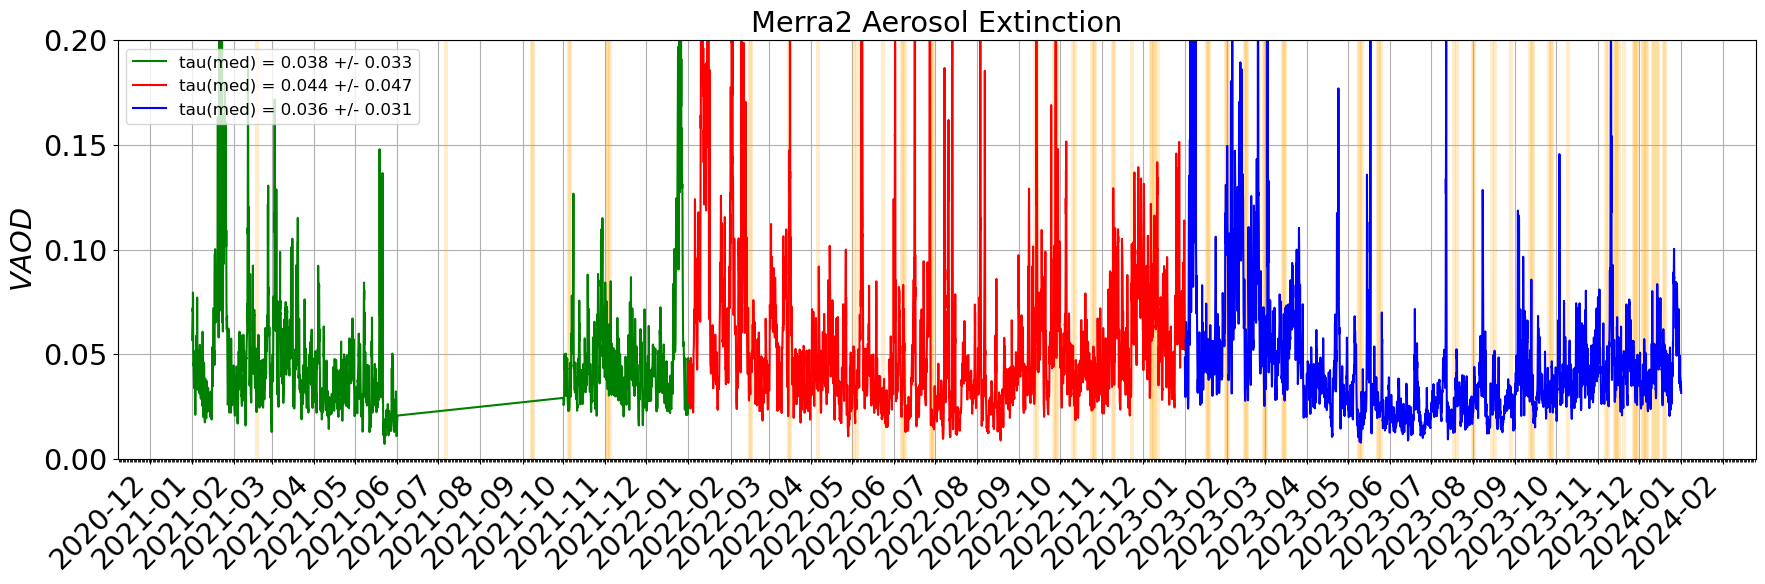

In [29]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

label1 = f"tau(med) = {aer_tau[0,0]:.3f} +/- {aer_tau[0,1]:.3f}"
label2 = f"tau(med) = {aer_tau[1,0]:.3f} +/- {aer_tau[1,1]:.3f}"
label3 = f"tau(med) = {aer_tau[2,0]:.3f} +/- {aer_tau[2,1]:.3f}"

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-',label=label1)
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-',label=label2)
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-',label=label3)

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.legend()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")
plt.tight_layout()
plt.savefig("Merra2_VAODHistRecord.png")
plt.show()

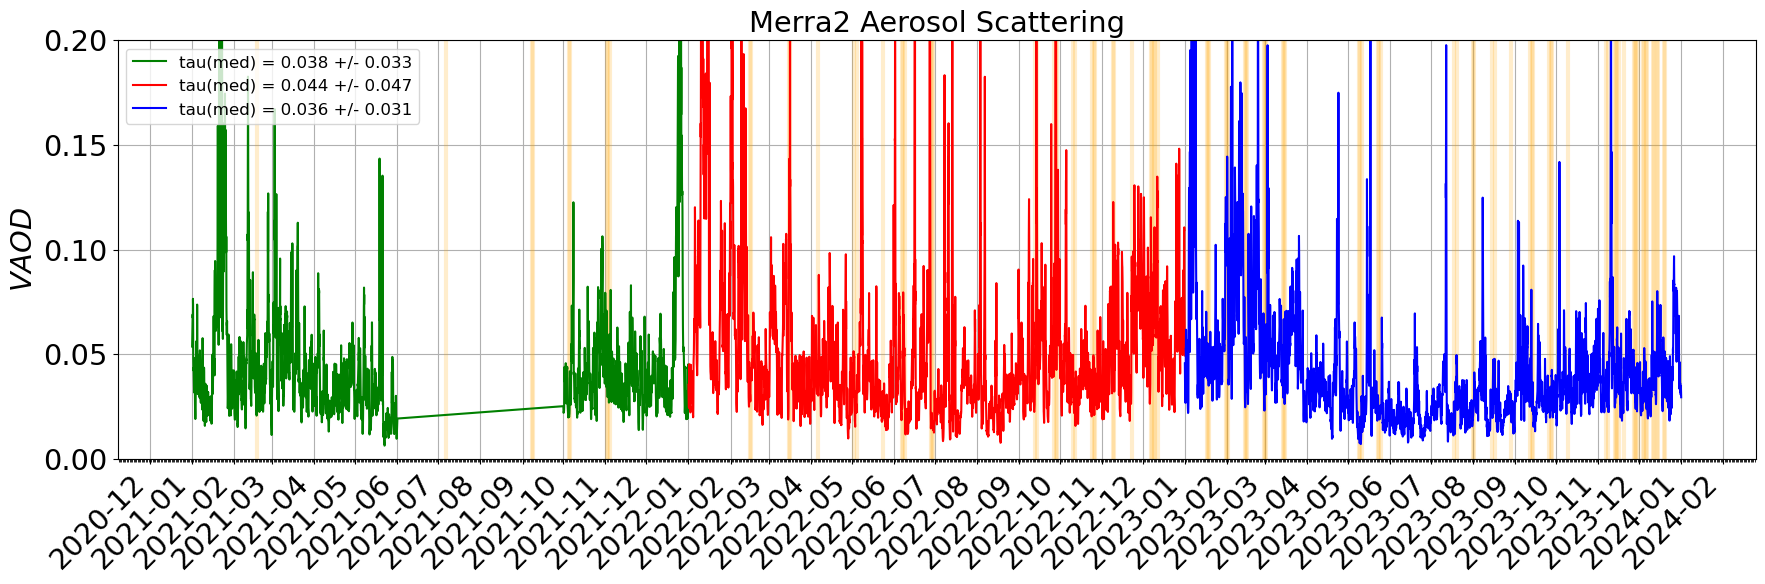

In [30]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)
    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-',label=label1)
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-',label=label2)
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-',label=label3)

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.legend()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")
plt.tight_layout()
plt.savefig("Merra2_AerExtinctHistRecord.png")

plt.show()

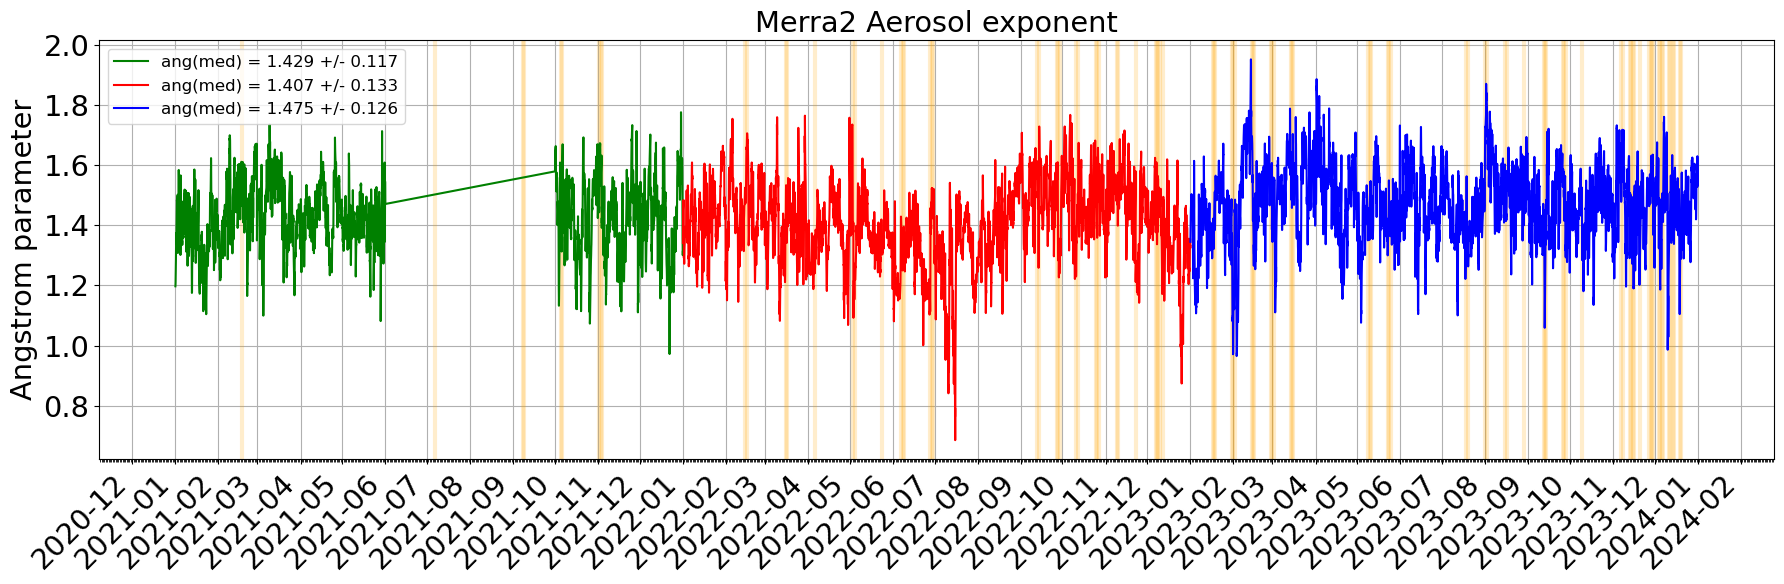

In [31]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

label1 = f"ang(med) = {aer_ang[0,0]:.3f} +/- {aer_ang[0,1]:.3f}"
label2 = f"ang(med) = {aer_ang[1,0]:.3f} +/- {aer_ang[1,1]:.3f}"
label3 = f"ang(med) = {aer_ang[2,0]:.3f} +/- {aer_ang[2,1]:.3f}"

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-',label=label1)
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-',label=label2)
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-',label=label3)

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.legend()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")
plt.tight_layout()
plt.savefig("Merra2_AerAngstromHistRecord.png")
plt.show()